In [10]:
#%% Setup.

# Activate environment.
! . ~/env/bin/activate

# Requirements.

! pip install --upgrade numpy torch scipy sklearn nibabel nilearn matplotlib

Requirement already up-to-date: numpy in /home/dcrowley/env/lib/python3.7/site-packages (1.16.4)
Requirement already up-to-date: torch in /home/dcrowley/env/lib/python3.7/site-packages (1.1.0)
Requirement already up-to-date: scipy in /home/dcrowley/env/lib/python3.7/site-packages (1.3.0)
Requirement already up-to-date: nibabel in /home/dcrowley/env/lib/python3.7/site-packages (2.4.1)
Requirement already up-to-date: nilearn in /home/dcrowley/env/lib/python3.7/site-packages (0.5.2)
Requirement already up-to-date: matplotlib in /home/dcrowley/env/lib/python3.7/site-packages (3.1.0)
     |████████████████████████████████| 6.7MB 5.6MB/s 
  Using cached https://files.pythonhosted.org/packages/cd/c1/50a758e8247561e58cb87305b1e90b171b8c767b15b12a1734001f41d356/joblib-0.13.2-py2.py3-none-any.whl


In [11]:
#%% Imports.

import numpy as np
import ardent

import matplotlib
%matplotlib inline

# TODO: remove with ardent.io.
from pathlib import Path
import nibabel as nib 

/home/dcrowley/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
#%% Load template and target.

directory_path = Path('/home/dcrowley/image_lddmm_tensorflow')
atlas_image_filename = 'average_template_50.img'
target_image_filename = '180517_Downsample.img'

atlasPath = directory_path / atlas_image_filename
targetPath = directory_path / target_image_filename

atlas = np.array(nib.load(str(atlasPath)).get_data()).astype(float).squeeze()
target = np.array(nib.load(str(targetPath)).get_data()).astype(float).squeeze()

In [13]:
#%% Reform and normalize images.

# Normalize.
# Compute mean absolute deviation.
atlas_mean_absolute_deviation = np.mean(np.abs(atlas - np.median(atlas)))
target_mean_absolute_deviation = np.mean(np.abs(target - np.median(target)))
# Subtract mean.
atlas -= np.mean(atlas)
target -= np.mean(target)
# Divide by mean absolute deviation.
atlas /= atlas_mean_absolute_deviation
target /= target_mean_absolute_deviation

# Pad with zeros.
atlas = np.pad(atlas, pad_width=5, mode='constant', constant_values=0)
target = np.pad(target, pad_width=5, mode='constant', constant_values=0)

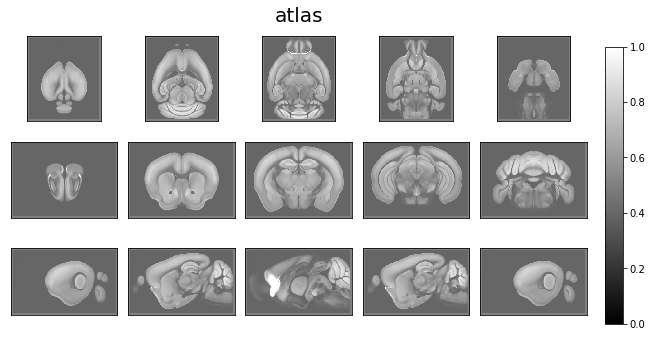

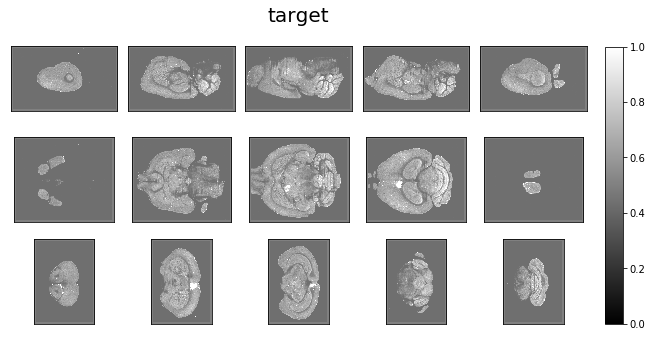

In [14]:
#%% Visualize images before registration.
# It is important to check that the images are oriented to one another 
# and do not require rotating or flipping.

ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(target, title='target', limit_mode='stdev')

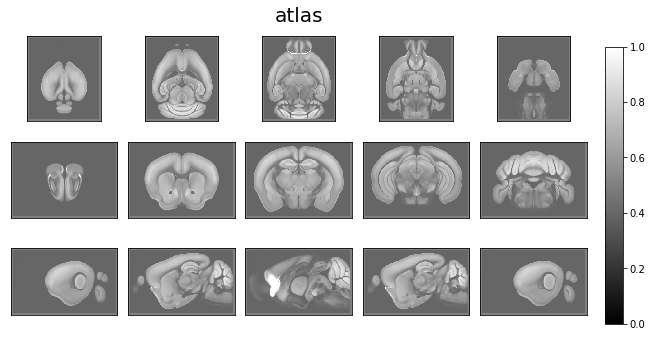

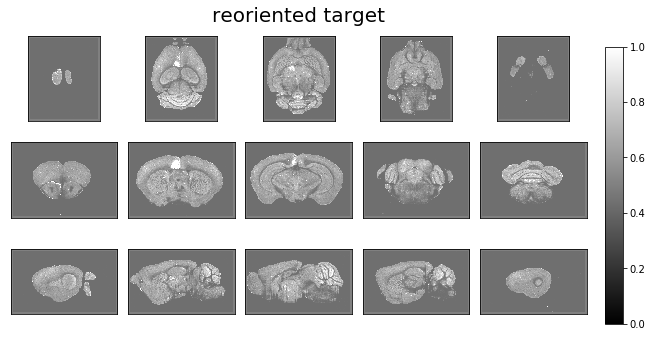

In [15]:
#%% Orient images.
# From looking at the two images we can see that they are not oriented.
# This must be corrected for prior to performing the registration.

# Here we will orient the target to the template (atlas).
reoriented_target = np.copy(target)
reoriented_target = np.rot90(reoriented_target, axes=(1,2))
reoriented_target = np.rot90(reoriented_target, axes=(2,0))
# np.moveaxis does nothing when destination == source.
# reoriented_target = np.moveaxis(reoriented_target, source=[0,1,2], destination=[0,1,2])
reoriented_target = np.flip(reoriented_target, axis=0)
reoriented_target = np.flip(reoriented_target, axis=1)

# If we performed an odd number of inversions with the above line, 
# we must perform a flip to correct for inverting the image. 
# The simplest flip is a sagittal flip, since that is the axis of innate symmetry in the brain.
# In this case, we can see from the atlas visualization that this is axis 2 (the last row).
# The above line performed 2 inversions, so the following line is commented out.
# reoriented_target = np.flip(reoriented_target, axis=2)

# Verify proper orientation.
ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(reoriented_target, title='reoriented target', limit_mode='stdev')

In [16]:
#%% Use reoriented target.
# Once we've finished orienting target, we use the result as target.
# A copy is taken to get a real array rather than a view.
target = reoriented_target.copy()

# Pad images to same shape.
atlas, target = ardent.lddmm.torch_lddmm_wrapper._pad_to_same_shape(atlas, target)

In [18]:
#%% Perform registration.

# Instantiate Transform object.
transform = ardent.Transform()

transform.register(template=atlas, target=target, 
    sigmaR=1e6, eV=0.1, niter=5)


Current parameters:
>    a               = 2 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 5 (number of iterations)
>    epsilon         = 0.1 (gradient descent step size)
>    epsilonL        = 0 (gradient descent step size, affine)
>    epsilonT        = 0 (gradient descent step size, translation)
>    minbeta         = 1e-15 (smallest multiple of epsilon)
>    sigma           = 1.0 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 1000000.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 1 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CUDA_VISIBLE_

In [19]:
#%% Apply the transformation.
# The transformation is the result of the registration, and it can be applied to arbitrary images, 
# although presently they should be preprocessed as the atlas and target were.
# Here we will simply apply the transformation to both the atlas and target, 
# making them match up with each other.
# i.e. deformed_target should resemble atlas, and deformed_atlas should resemble target.

deformed_atlas = transform.apply_transform(subject=atlas, deform_to='target', save_path=None)
deformed_target = transform.apply_transform(subject=target, deform_to='template', save_path=None)

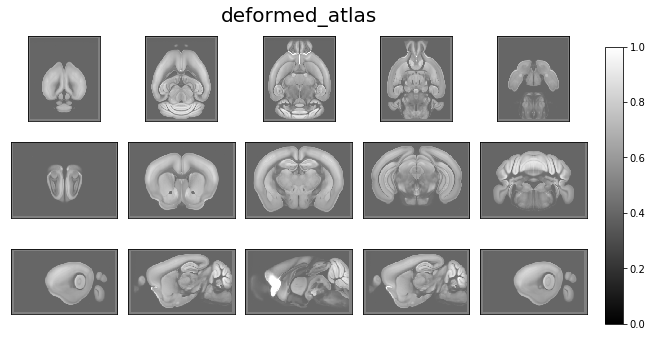

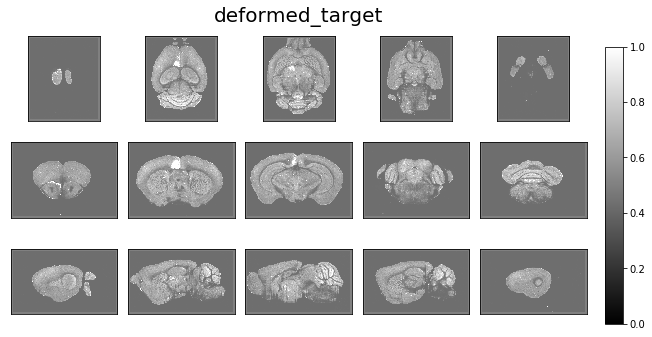

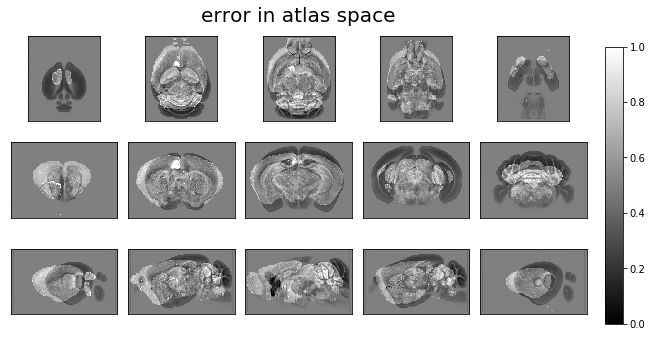

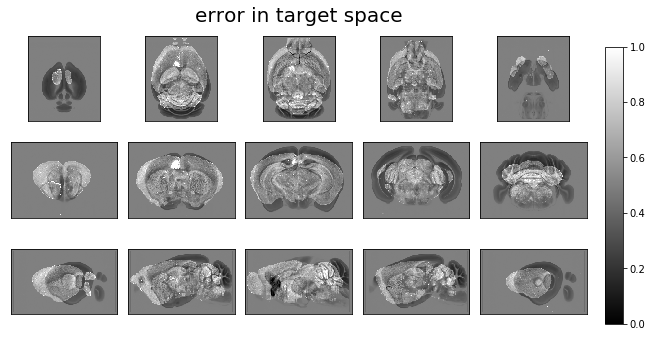

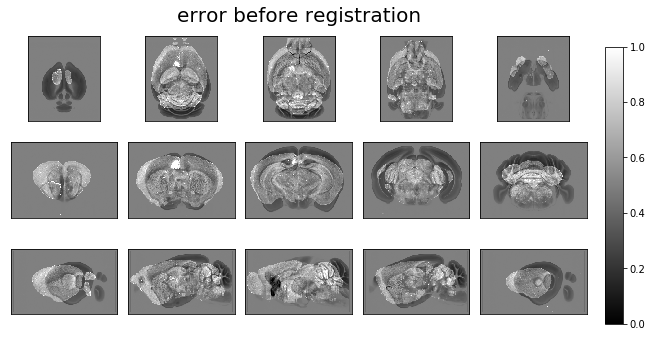

In [21]:
#%% Visualize results.

ardent.heatslices(deformed_atlas, title='deformed_atlas', limit_mode='stdev')
ardent.heatslices(deformed_target, title='deformed_target', limit_mode='stdev')

# To simply visualize error we plot the difference between images.
ardent.heatslices(deformed_target - atlas, title='error in atlas space', limit_mode='stdev')
ardent.heatslices(target - deformed_atlas, title='error in target space', limit_mode='stdev')
ardent.heatslices(target - atlas, title='error before registration', limit_mode='stdev')